In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from cheyette.curves import FlatCurve
from cheyette.products import ZCBCall
from cheyette.processes import VasicekProcess
from cheyette.discretization import PeacemanRachford
from cheyette.boundary_conditions import DirichletIntrinsicBC
from cheyette.models import CheyettePDEModel, CheyetteAnalyticModel
from cheyette.pricers import CheyettePricer

plt.style.use('input/qulib.mplstyle')

# Bond option pricing

In [25]:
curve = FlatCurve(short_rate=0.01)
process = VasicekProcess(mean_rev=0.10, local_vol=0.01)

model_pde = CheyettePDEModel(x_grid_stddevs=5.0, y_grid_stddevs=5.0,
                    x_freq=3, y_freq=3, t_freq=10,
                    stepping_method=PeacemanRachford(),
                    x_lower_bc=DirichletIntrinsicBC(), x_upper_bc=DirichletIntrinsicBC(),
                    y_lower_bc=DirichletIntrinsicBC(), y_upper_bc=DirichletIntrinsicBC())

model_analytic = CheyetteAnalyticModel()

product = ZCBCall(strike=0.98, expiry=1.0, bond_expiry=2.0)

pricer_pde = CheyettePricer(model_pde, curve, process, product, valuation_time=0.0)
pricer_analytic = CheyettePricer(model_analytic, curve, process, product, valuation_time=0.0)

notional = 10000.0

pv_pde = pricer_pde.price()['PV']*notional
pv_analytic = pricer_analytic.price()['PV']*notional

print(f'PDE PV: {pv_pde}')
print(f'Analytic PV: {pv_analytic}')
print(f'Abs. Error: {pv_pde - pv_analytic}')

PDE PV: 105.30588758503788
Analytic PV: 105.25383351306373
Abs. Error: 0.05205407197415468


## FDM Convergence

In [18]:
pv_freq_analytic = pricer_analytic.price()['PV']*notional

freqs = np.arange(3, 22, 3)
pvs_freq_pde = [pricer_pde.set('model', model_pde.set('x_freq', f).set('y_freq', f)).price()['PV']*notional for f in freqs]

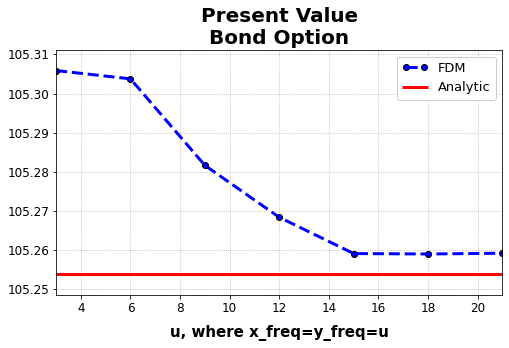

In [20]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(freqs, pvs_freq_pde, label='FDM')
ax.set_xlabel('u, where x_freq=y_freq=u')
ax.set_title('Present Value\nBond Option')
ax.hlines(pv_freq_analytic, freqs[0], freqs[-1], color='r', label='Analytic')
ax.legend()

# Curve Bumps

In [3]:
short_rates = np.arange(-0.05, 0.0501, 0.01)
pvs_curve_pde = [pricer_pde.set('curve', curve.set('short_rate', r)).price()['PV']*notional for r in short_rates]
pvs_curve_analytic = [pricer_analytic.set('curve', curve.set('short_rate', r)).price()['PV']*notional for r in short_rates]

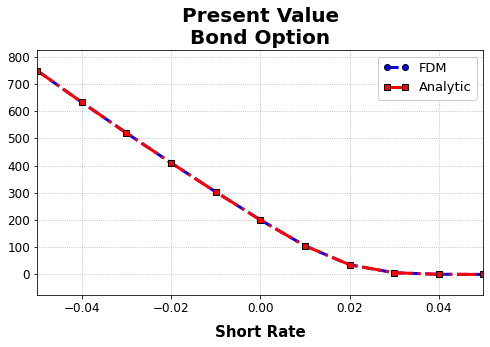

In [4]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, pvs_curve_pde, label='FDM')
ax.plot(short_rates, pvs_curve_analytic, label='Analytic')
ax.set_xlabel('Short Rate')
ax.set_title('Present Value\nBond Option')
ax.legend()

# Volatility Bumps

In [ ]:
mults = np.arange(-0.9, 2.1, 0.1)
default_vol = 0.02
model_pde.set('x_freq', 3).set('y_freq', 3)
pvs_vols_pde = [pricer_pde.set('process', process.set('local_vol', (1+m)*default_vol)).price()['PV']*notional for m in mults]
pvs_vols_analytic = [pricer_analytic.set('process', process.set('local_vol', (1+m)*default_vol)).price()['PV']*notional for m in mults]

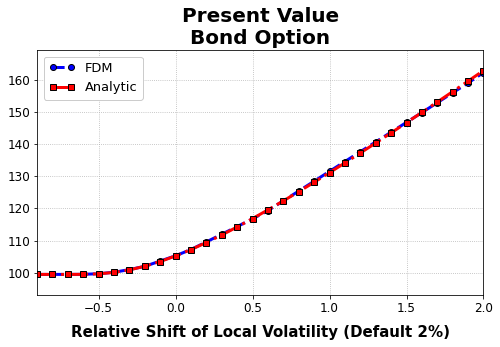

In [30]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, pvs_vols_pde, label='FDM')
ax.plot(mults, pvs_vols_analytic, label='Analytic')
ax.set_xlabel(f'Relative Shift of Local Volatility (Default {default_vol})')
ax.set_title('Present Value\nBond Option')
ax.legend()